# Chapter 1: AutoRegressive Integrated Moving Average (ARIMA)

Prepared by: Benjur Emmanuel L. Borja and Maria Eloisa M. Ventura

In this notebook, we will introduce our first approach to time-series forecasting which is **ARIMA** or AutoRegressive Integrated Moving Average. This notebook will discuss:
1. Definition and Formulation of ARIMA models
2. Model Parameters (p, d, and q) and Special Cases of ARIMA models
3. Model Statistics and How to Interpret
4. Implementation and Forecasting using ARIMA

In [1]:
#Import required Libraries
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

## Introduction to ARIMA

ARIMA, or AutoRegressive Integrated Moving Average, is a set of models that explains a time series using its own previous values given by the lags (**A**uto**R**egressive) and lagged errors (**M**oving **A**verage) while considering stationarity corrected by differencing (oppossite of **I**ntegration.) In other words, ARIMA assumes that the time series is described by autocorrelations in the data rather than trends and seasonality. In these context, we define trends and seasonality as the following:
- **Trend**: A time series has a trend if there is a overlying long term increase or decrease in the data, which is not necessarily linear. 
- **Seasonality**: A time series data has seasonality when it is affected by seasonal factors such as the time of the year or the day of the week. The seasonality of data is apparent as there is a fixed frequency of pattern occurence. 

### Example 1: Stationary and Non-Stationary Univartiate Time Series

To illustrate, lets look at the following examples of time series (__[source](https://otexts.com/fpp2/fpp_files/figure-html/stationary-1.png)__):

(a) Google stock price for 200 consecutive days

(b) Daily change in the Google stock price for 200 consecutive days

(c) Annual number of strikes in the US

(d) Monthly sales of new one-family houses sold in the US; (e) Annual price of a dozen eggs in the US (constant dollars)

(f) Monthly total of pigs slaughtered in Victoria, Australia

(g) Annual total of lynx trapped in the McKenzie River district of north-west Canada; (h) Monthly Australian beer production

(i) Monthly Australian electricity production.

![stationary-1.png](stationary-1.png)

**Which of these series are stationary?** 

Obvious seasonality rules out series (d), (h) and (i). Trends and changing levels rules out series (a), (c), (e), (f) and (i). Increasing variance also rules out (i). That leaves only (b) and (g) as stationary series. At a first glance, (g) might seem non-stationary but these cycles are aperiodic, and is dependedent on the complex interactions between lynx population and the availability of the food source. The timing of these cycles is unpredictable hence, this time series is non-stationary.

Now notice the Google Stock Price (a) and the daily change in the Google Stock Price (b). These time-series came from the same system, but exhibits different dynamics. This illustrates that we can make non-stationary time-series stationary by taking the difference between consecutive observations - or **Differencing**. Differencing stabilizes our time-series by removing changes in the level of our time series, therefore reducing trends and seasonality.

### Model Components

As previously mentioned, ARIMA models are built given the following key aspects:

**AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.  
**I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.  
**MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.  

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used:  
**p**: The number of lag observations included in the model, also called the lag order (*deals with **window** of $X_t$*)  
**d**: The number of times that the raw observations are differenced, also called the degree of differencing (*deals with order of **differencing** of $X_t$*)  
**q**: The size of the moving average window, also called the order of moving average (*deals with **residuals***)  

Given this, the general case of ***ARIMA(p,d,q)*** can be written as:

\begin{equation}
X_{t} = \alpha _{1}X_{t-1} + \dots + \alpha _{p}X_{t-p} + \varepsilon _{t}+\theta_{1}\varepsilon _{t-1}+\cdots +\theta _{q}\varepsilon _{t-q}
\end{equation}

Or in words : 

**Predicted $X_t$** = Constant + Linear combination of **Lags of $X$ (up to $p$ lags)** + Linear Combination of **Lagged forecast errors (up to q lags)**. Provided that the time-series is already **differenced (up to d terms)** to ensure stationarity. 

## Model parameters *p, d, and q* and Special Cases

Before we discuss how we determine p, d, and q that are best to represent a time series, let's first take a look at special cases of ARIMA models that should help us illustrate the formulation of the ARIMA equation.

**Case 1: ARIMA(p,0,0) = autoregressive model**: if the series is stationary and autocorrelated, perhaps it can be predicted as a multiple of its own previous value, plus a constant.

The forecasting equation for ARIMA(1,0,0) is:

\begin{equation}
X_{t}  =  \mu  + \alpha _{1}X_{t-1}
\end{equation}

while ARIMA(2,0,0)

\begin{equation}
X_{t}  =  \mu  + \alpha _{1}X_{t-1} +  \alpha _{2}X_{t-2}
\end{equation}

or in general ARIMA(p,0,0)

\begin{equation}
X_{t}  =  \mu  + \alpha _{1}X_{t-1} +  \alpha _{2}X_{t-2} \dots + \alpha _{p}X_{t-p}
\end{equation}

**Case 2: ARIMA(0,0,q) = moving average model**: if the series is stationary but is correlated to the errors of previous values, we can regress using the past forecast errors.

The forecasting equation for this is ARIMA(0,0,1) given by:

\begin{equation}
X_{t} = \varepsilon _{t}+\theta_{1}\varepsilon _{t-1}
\end{equation}

or in simillar fashion to p, this can be generalized to ARIMA(0,0,q):

\begin{equation}
X_{t} = \varepsilon _{t}+\theta_{1}\varepsilon _{t-1}+\cdots +\theta _{q}\varepsilon _{t-q}
\end{equation}

where $\theta_{q}$ is the coefficient at time $t-q$ of the residual $\varepsilon _{t-q}$.


**Case 3: ARIMA(0,1,0) = Random Walk**: if the series is non-stationary then the simplest model that we can use is a random walk model, which is given by:

\begin{equation}
X_{t}  =  \mu  + X_{t-1}
\end{equation}

*This can then further be generalized to ARIMA(0,d,0) simillar to the first two cases.*



As shown in our cases, we can use value of 0 for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model. **It is good to note that the case ARIMA(0,1,1) is a Simple Exponential Smoothing model** but we'll leave that in another discussion.

Implementing an ARIMA model for a time series assumes that the observations is an ARIMA process. To implement ARIMA, a linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

### Determining *p*, *d*, and *q*

We need to explicitly indicate p, d, and q when implementing ARIMA models. Selecting appropriate p, d, and q can be difficult but there are several methods of automating this process. For example, we can use grid search in python to scan through different values and check which model would be optimal (will be discussed later.) R uses the auto.arima() function to do this automatically. For our case, we will look at the Augmented-Dickey Fuller Test (ADF), AutoCorrelation Function (ACF), and Partial Autocorrelation Function (PACF) to determine our model parameters.

#### Finding the order differencing *d*

As stated before, ARIMA models are assumed to be stationary. Implementing differencing may induce stationarity for various time series. The quickest way to determine *d* for our models is to difference and simply run ADF to check for stationarity. We can also look at the PACF and ACF to see if our time series is stationary after *d* differencing.

To illustrate, let's take a look at the following example:

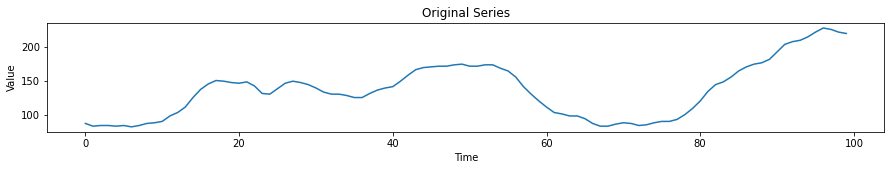

In [2]:
# We're using a sample data from https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv
# Import data
df = pd.read_csv('../data/wwwusage.csv', names=['value'], header=0)
plt.figure(figsize=(15, 2))
plt.plot(df)
plt.title('Original Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Initial eyeballing shows that there is a trend for this time series and is non-stationary. Checking using ADF:

In [3]:
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary. For our example, we fail to reject the null hypothesis.

Next we difference our time series and check the results of the ADF test. We will also look at the ACF.

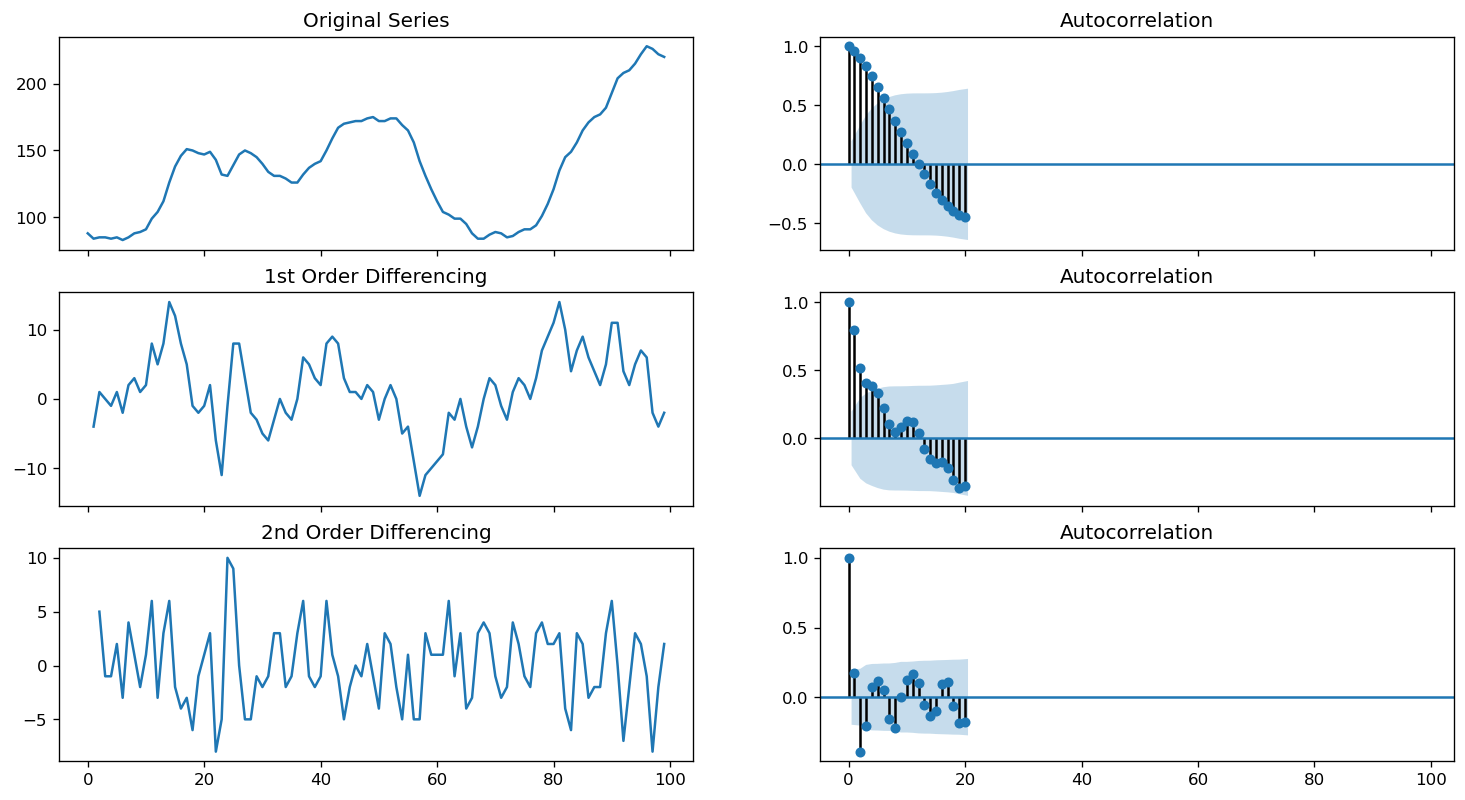

ADF Statistic for 1st Order Differencing
ADF Statistic: -2.722238
p-value: 0.070268
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -9.929762
p-value: 0.000000
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583


In [4]:
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

print('ADF Statistic for 1st Order Differencing')
result = adfuller(df.value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(df.value.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Given the results of our ACF and ADF, we can see that our time series reachees stationarity after two orders of differencing. However, the ACF of the 2nd order differencing goes into the negative zone fairly quick. This can indicates that the series might have been over differenced. It is now up to us if we want consider the first or second order differencing for our ARIMA models.

#### Finding the order of the AutoRegressive term *p*

As we have discussed previously, we can look at the PACF plot to determine the lag for our AR terms. Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, we will know if that lag is needed in the AR term or not.

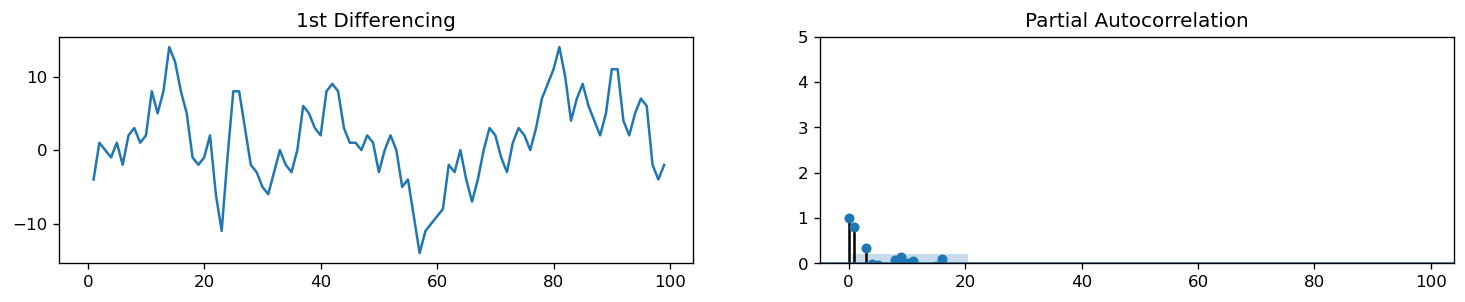

In [5]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Immediately, we can observe that our PACF returns sigificance at Lag 1 and Lag 2, meaning it crosses the significance limit (blue region). We can also observe significance at higher order terms but note that given the amount of lag that we are testing, it is statistically probable to see random spikes in our PACF and ACF plots. *Although this can also be attributed to Seasonality which will be tackled separately.*

With this, we can now decide to use $p = 2$ for our ARIMA model.

#### Finding the order of the Moving Average term *q*

Simillar to how we determined $p$, we will now look at the ACF to determine the $q$ terms to be considered for our MA. The ACF tells how many MA terms are required to remove any autocorrelation in the stationary series.

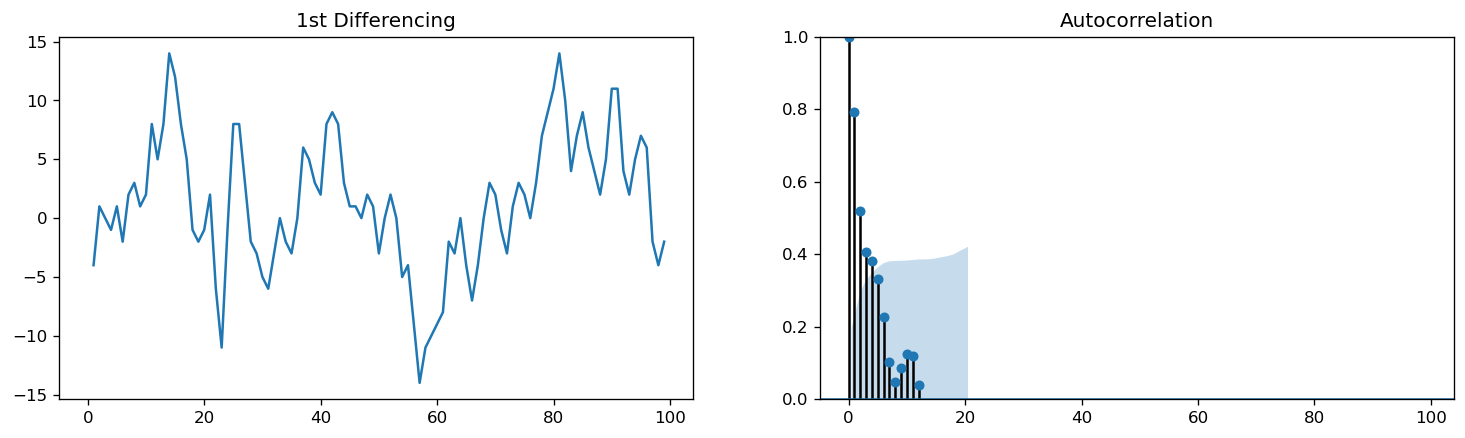

In [6]:
# ACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Our results for the ACF is not as apparent compared to our PCF. We can observed several ACF terms that is above our significance level. This may be  attritbuted to the fact that our model has a weak stationarity. This may also be caused by the fact that our time series is not perfectly MA and is an ARIMA model. For now, let's consider $q = 3$.

## Building the ARIMA model
Now that we’ve determined the values of p, d and q, we have everything needed to fit the ARIMA model. Let's implement using this dataset first before we move on to a deeper look at the implementation of ARIMA in the next section. Let’s use the ARIMA() implementation in statsmodels package. As computed, we will use ARIMA(2,1,3):

In [7]:
model = ARIMA(df.value, order=(2,1,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -251.701
Method:                       css-mle   S.D. of innovations              3.050
Date:                Sun, 21 Feb 2021   AIC                            517.402
Time:                        00:47:38   BIC                            535.568
Sample:                             1   HQIC                           524.752
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0049      1.584      0.635      0.526      -2.099       4.109
ar.L1.D.value     0.5502      0.299      1.840      0.066      -0.036       1.136
ar.L2.D.value     0.2364      0.217     

There's quite a bit of information to unpack from the summary. Generally, we are interested in the Akaike’s Information Criterion (AIC), coefficients of our AR and MA terms (coef_), and the p-values of the terms (P>|z|). We need the p-values to be less than 0.05 to be significant, which means that our model failed to reach significance for the AR and MA terms. Let's try to be conservative and use small values for p and d, i.e. ARIMA(1,1,1), as given by the p-values of AR1 and MA1 in our results.

In [8]:
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Sun, 21 Feb 2021   AIC                            515.579
Time:                        00:47:38   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

Immediately, we can see that the p-values is now  <<0.05 for both the AR and MA terms and is highly significant. We will now check the residuals of our time-series to ensure that we will not see patterns and will have a constant mean and variance.

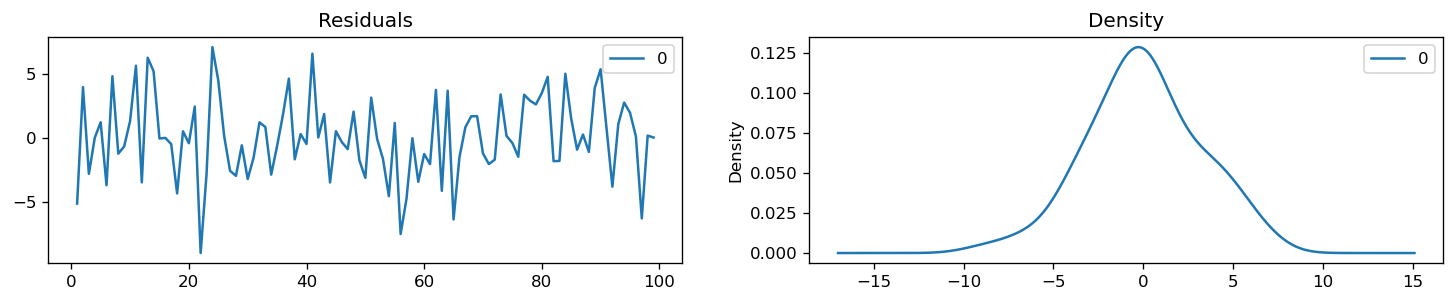

In [9]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,2.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residuals is a good final check for our ARIMA models. Ideally, the residual errors should be a Gaussian with a zero mean and uniform variance. With this, we can now proceed with fitting our initial time series with our model.

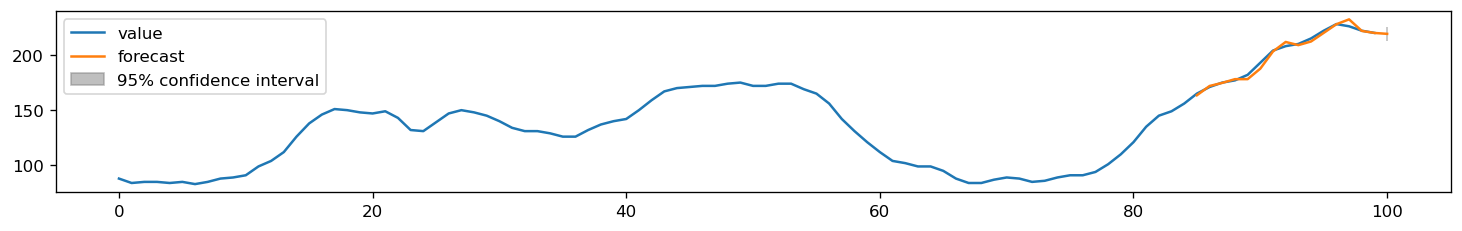

In [10]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize=(15,2))
ax = df.plot(ax=ax)
fig = model_fit.plot_predict(85, 100, dynamic=False, ax=ax, plot_insample=False)
plt.show()

When we set dynamic=False the in-sample lagged values are used for prediction. That is, the model gets trained up until the previous value to make the next prediction. We can also call this as a **walk-forward** or **one-step ahead** prediction.

However, we should note two things:
1. We used the entire time series to train our model
2. Some of the use-cases that we will be tackling will require us to forecast t-steps ahead

We will be solving the first point in the next section by tackling real-world datasets. The second point can be solved immediately using dynamic=True argument shown below.

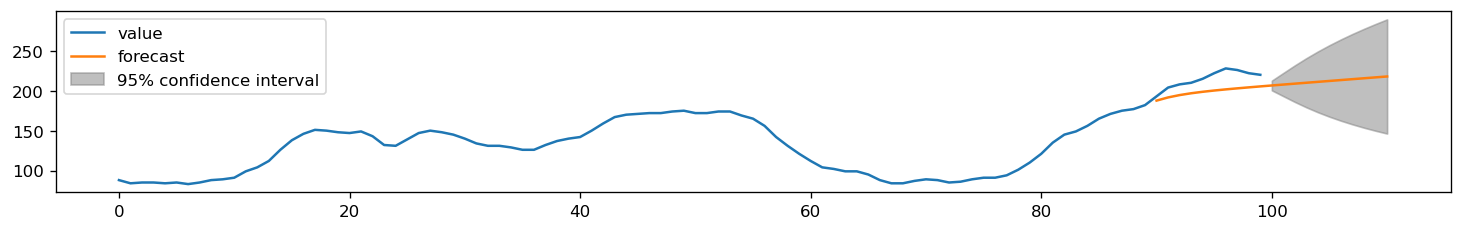

In [11]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize=(15,2))
ax = df.plot(ax=ax)
fig = model_fit.plot_predict(90, 110, dynamic=True, ax=ax, plot_insample=False)
plt.show()

Notice that our confidence interval is now increasing as we go farther our given data set since we will be compounding errors given by out forecasted values. Also note that generally, our ARIMA model captured the direction of the trend of our time series but is consistently lower than the actual values. We can correct this by varying the parameters of our ARIMA models and validating using performance metrics. 

## Implementation and Forecasting using ARIMA


Given the steps discussed in the first three sections of this notebook, we can now create a framework of how we can approach ARIMA models in general. We can use a modified version of the Hyndman-Khandakar algorithm (Hyndman & Khandakar, 2008), which combines unit root tests, minimisation of the AIC and MLE to obtain an ARIMA model. The steps are outlined below: 

1. The differencing term d is determined using repeated ADF tests.
2. The values of p and q are chosen based on the AIC, ACF, and PACF of our differenced time series.
3. Use a step-wise traversal of our parameter space (+-1) for p, d, and q to find a lower AIC. *We can use insights and heuristics to observe our ACF and PACF to determine if we need to add or reduce our p, d, and q.*
4. Check the residuals for Gaussian Distribution to establish stationarity.

Or in our case, we will instead use a grid-search algorithm to find automatically configure our ARIMA and find our hyperparameters. We will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance on the test set. We use grid search to explore all combinations in a subset of integer values.

Specifically, we will search all combinations of the following parameters:

p: 0 to 4. d: 0 to 3. q: 0 to 4. This is (4 * 3 * 4), or 48, potential runs of the test harness and will take some time to execute.

The complete worked example with the grid search version of the test harness is listed below.

In [12]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order, train_size=None):
    # prepare training dataset
    X = X.astype('float32')
    if train_size is None:
        train_size = int(len(X) * 0.50)
    else:
        train_size = int(train_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        diff = difference(history, 1)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, 1)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mae = mean_absolute_error(test, predictions)
    return mae


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


### Example 2: Forecasting Temperature in Jena Climate Data

We now use the method above to perform **multi-step forecasting** (24-step) in the Jena temperature data. 

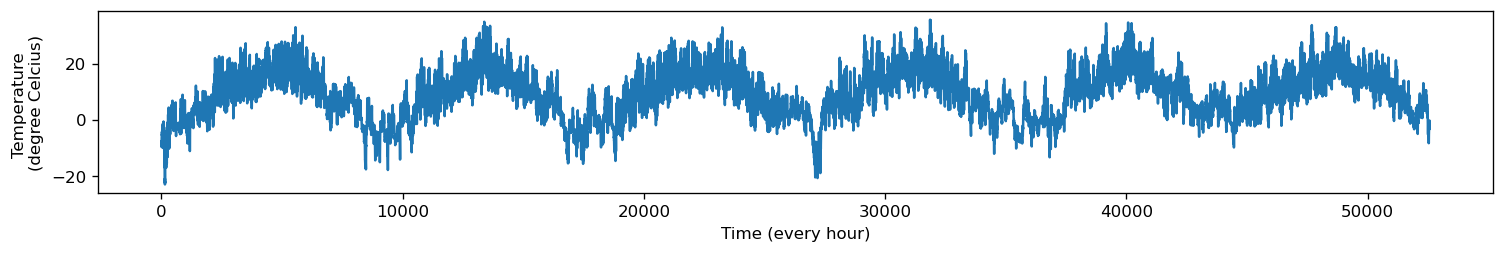

In [13]:
train_data = pd.read_csv('../data/train_series.csv',index_col=0).loc[:, ['T (degC)']]
val_data = pd.read_csv('../data/val_series.csv',index_col=0).loc[:, ['T (degC)']]
temp = pd.concat([train_data, val_data]).values  #temperature (in degrees Celsius)
plt.figure(figsize=(15,2))
plt.plot(range(len(temp)), temp)
plt.ylabel('Temperature \n(degree Celcius)')
plt.xlabel('Time (every hour)')
plt.show()

#### Model order selection (hyperparameter tuning)

Before we proceed with the grid-search algorithm, we perform some preliminary tests on the time series to narrow down our parameter search. We can start by checking the stationarity of the signal to estimate $d$. Then, we plot the PACF and ACF of the time series to estimate $p$ and $q$, respectively. 

In [14]:
result = adfuller(temp)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.958617
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


**Observation**: Based on the results of the ADF test, the signal is stationary. This implies that $d=0$ so we no longer need to perform differencing. 

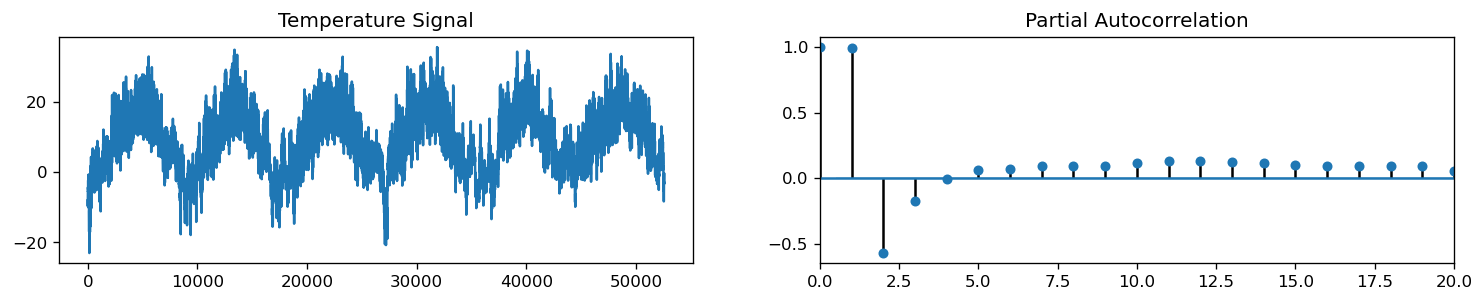

In [15]:
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(temp.flatten())
axes[0].set_title('Temperature Signal')
axes[1].set(xlim=(0,20))
plot_pacf(temp.flatten(), ax=axes[1])
plt.show()

**Observation**: Based on the plot of the PACF, we can see that the function drops to a value of almost zero for lags > 2. So, we can set $p$ to be from 0 to 2. 

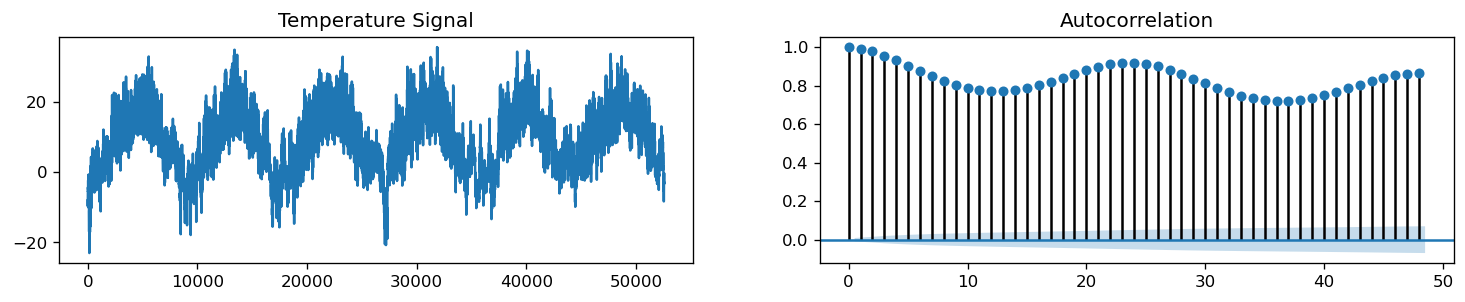

In [16]:
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(temp.flatten())
axes[0].set_title('Temperature Signal')
plot_acf(pd.Series(temp.flatten()), ax=axes[1])
plt.show()

**Observation**: Unlike the PACF which displayed a sharp cutoff, the ACF decays more slowly. We can say that the  series has an *autoregressive signature* which means that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms. Let's test for values $q$ from 0 to $5$.

Due to constraints in computing resources, we will limit the length of the training data (from 35045 to 17524). We will also reduce the number of folds to be used (from 730 to 20).  

In [17]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_jena_24hrstep(X, arima_order, train_size=35045):
    # prepare training dataset
    X = X.astype('float32')
    train, test = X[:train_size], X[train_size:]
    test = test[:len(X[train_size:]) - len(X[train_size:])%24]
    test_24 = test.reshape(-1, 24)
    history = train.flatten()

    mae_cv = []
    # There are 730 folds (24 hr chunks), for faster computation, we limit the number of folds to 20 only
    for t in range(len(test_24))[::37]:
        x_cv = np.hstack([history, test_24[:t, :].flatten()])
        y_cv = test_24[t]
        model = ARIMA(x_cv, order=arima_order)
        model_fit = model.fit(disp=0)
        y_hat = model_fit.forecast(steps=24)[0]
        mae_cv.append(mean_absolute_error(y_cv, y_hat))
    mean_mae = np.mean(mae_cv)
    return mean_mae

In [18]:
## Uncomment the lines to perform model order selection
# arima_orders = [(0, 0, 0), 
#                 (1, 0, 0), 
#                 (0, 0, 1),
#                 (2, 0, 0),
#                 (1, 0, 1), 
#                 (1, 0, 2), 
#                 (2, 0, 1), 
#                 (2, 0, 2)]
# mae_ao_list = []
# for ao in arima_orders:
#     mae_ao = evaluate_arima_jena_24hrstep(temp[-2*len(val_data):], 
#                                           arima_order=ao, 
#                                           train_size=len(val_data))
#     mae_ao_list.append((ao, mae_ao))
#     print(ao, mae_ao)
    
# selected_order, best_mae = np.array(mae_ao_list)[np.argmin(np.array(mae_ao_list)[:,-1])]
# print(f'Selected order: {selected_order}, MAE: {best_mae}')

In [19]:
## Expected results from code above: 
## (p, d, q) MAE
## ---------------------------
## (0, 0, 0) 6.035602297003233
## (1, 0, 0) 3.025640357465662
## (0, 0, 1) 5.922866295058727
## (2, 0, 0) 3.124825200033295
## (1, 0, 1) 2.967933864811228
## (1, 0, 2) 2.9481444828018253 
## (2, 0, 1) 3.5091372748649037
## (2, 0, 2) 3.4143813707023325
## Selected order: (1, 0, 2), MAE: 2.9481444828018253

In [20]:
selected_order = (1, 0, 2)

#### Evaluate model performance on test set

We use the multiprocessing package which supports spawning processes using an API similar to the threading module. 

In [21]:
def wrapper_fit_arima(x_vals, order=(1, 0, 2)):
    model = ARIMA(x_vals, order=order)
    model_fit = model.fit(disp=0)
    y_hat = model_fit.forecast(steps=24)[0]
#     print(len(x_vals))
    return y_hat

def evaluate_arima_jena_mp(X, arima_order, train_size=35045):
    # prepare training dataset
    X = X.astype('float32')
    train, test = X[:train_size], X[train_size:]
    test = test[:len(X[train_size:]) - len(X[train_size:])%24]
    test_24 = test.reshape(-1, 24)
    history = train.flatten()
    
    X_cv = []
    Y_cv = []
    for t in range(len(test_24)):
        x_cv = np.hstack([history, test_24[:t, :].flatten()])
        y_cv = test_24[t]
        X_cv.append(x_cv)
        Y_cv.append(y_cv)

    pool = mp.Pool(processes=mp.cpu_count()-4)
    y_hats = pool.map(wrapper_fit_arima, X_cv)        
    
    mae_cv = []
    for t in range(len(test_24)):
        mae_cv.append(mean_absolute_error(Y_cv[t], y_hats[t]))
    mean_mae = np.mean(mae_cv)
    return mean_mae

In [22]:
# Load test data
test_data= pd.read_csv('../data/test_series.csv',index_col=0).loc[:, ['T (degC)']]
temp2 = pd.concat([val_data, test_data]).values  #temperature (in degrees Celsius)

We fit the ARIMA(1,0,2) model using the validation set to predict the 24-hour chunks of temperature measurements in the test set. 

In [23]:
## Uncomment code below to fit and predict temperature values in the test set
## By using CPU count of 28, the code ran for about 70 mins. 
# MAE = evaluate_arima_jena_mp(temp2, arima_order=selected_order, train_size=len(val_data))
# print(f'ARIMA MAE: {np.mean(MAE)}') 

## Expected result from running the code above:
## ARIMA MAE: 3.191548582794122
print('ARIMA MAE for Jena test data: 3.191548582794122')

ARIMA MAE for Jena test data: 3.191548582794122


**Observation/s**: The ARIMA(1,0,2) model had a poorer performance (ARIMA MAE: 3.19) on the test set compared to our [baseline models](../08_WinningestMethods/lightgbm_jena_forecasting.ipynb) (naive MAE: 3.18, seasonal naive MAE: 2.61).

##### Forecast 24 hours beyond test set

In [24]:
%%time
future_data = wrapper_fit_arima(temp2)
future_data

CPU times: user 24.7 s, sys: 25.2 s, total: 49.9 s
Wall time: 49.3 s


array([-4.28561198, -4.26056166, -4.02705644, -3.79736279, -3.57141847,
       -3.3491623 , -3.13053407, -2.91547455, -2.7039255 , -2.49582961,
       -2.29113051, -2.08977277, -1.89170183, -1.69686405, -1.50520666,
       -1.31667773, -1.1312262 , -0.94880183, -0.76935522, -0.59283776,
       -0.41920164, -0.24839981, -0.08038602,  0.08488524])

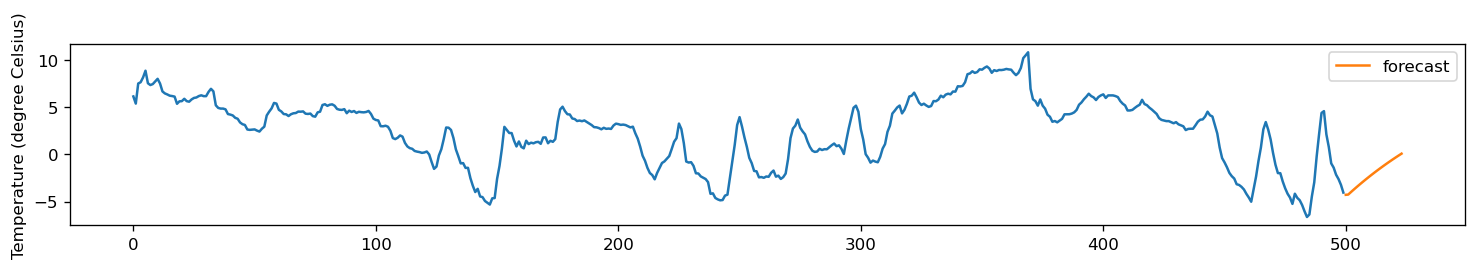

In [25]:
plt.figure(figsize=(15,2))
plt.plot(temp2[-500:])
plt.plot(np.arange(24)+500, future_data, label='forecast')
plt.legend()
plt.ylabel('Temperature (degree Celsius)')
plt.show()

### Example 3: Using ARIMA for Multivariate Time Series

In this final example, we use ARIMA to forecast different time series signals from an Air Quality Dataset measured in a polluted area at an Italian City. To illustrate, we forecast the data for the last 24 hours for CO, and NO2. The following figure shows the training data for each of these parameters. 

In [26]:
train_aq = pd.read_csv('../data/AirQualityUCI/train_data.csv',index_col=0).set_index('Date_Time')
test_aq = pd.read_csv('../data/AirQualityUCI/test_data.csv',index_col=0).set_index('Date_Time')
train_aq.head()

,CO(GT),NO2(GT),RH
Date_Time,,,
2004-10-01 01:00:00,1.6,74.0,69.275002
2004-10-01 02:00:00,1.3,69.0,70.775000
2004-10-01 03:00:00,0.8,61.5,65.833332
2004-10-01 04:00:00,0.6,54.0,67.174999
2004-10-01 05:00:00,0.7,60.0,70.275000


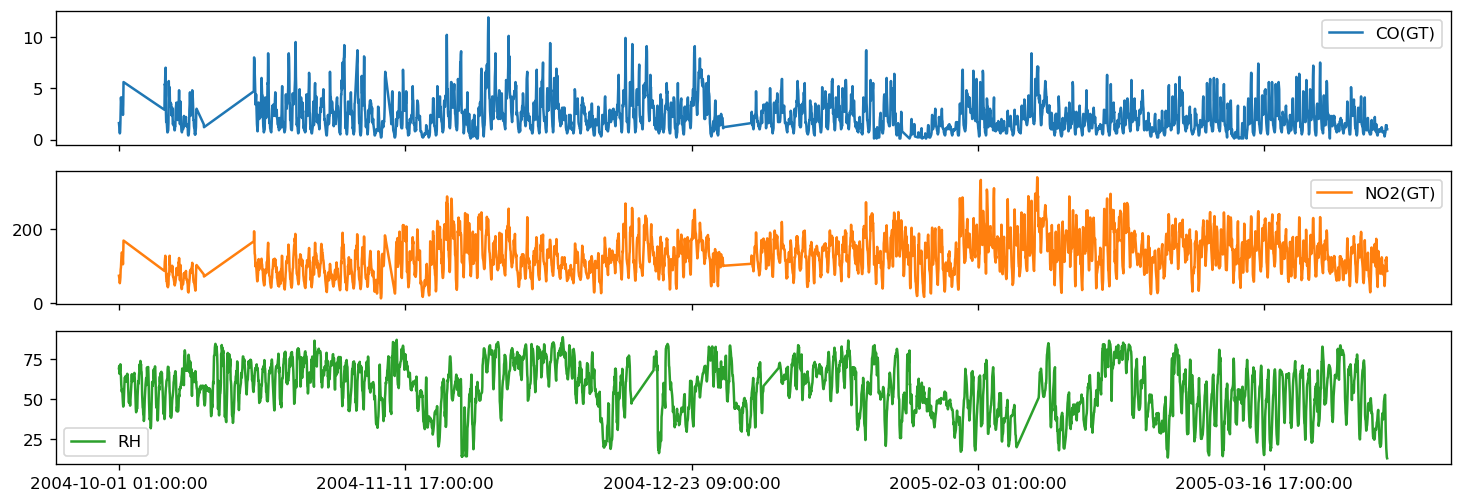

In [27]:
fig,ax = plt.subplots(3, figsize=(15, 5), sharex=True)
train_aq.plot(ax=ax, subplots=True)
plt.xlabel('')
plt.show()

In [28]:
def evaluate_arima_multistep(X, arima_order, train_size=None):
    # prepare training dataset
    X = X.astype('float32')
    if train_size is None:
        train_size = int(len(X) * 0.50)
    else:
        train_size = int(train_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast(steps=len(test))
    predictions = yhat[0]
    return mean_absolute_error(test, predictions)

def evaluate_models_mae(dataset, p_values, d_values, q_values, train_size=None):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mae = evaluate_arima_model_mae(dataset, order, train_size=train_size)
                    if mae < best_score:
                        best_score, best_cfg = mae, order
                    print('ARIMA%s MAE=%.3f' % (order,mae))
                except:
                    continue
    print('Best ARIMA%s AME=%.3f' % (best_cfg, best_score))

To make predictions, we train 3 ARIMA models—one for CO, one for NO2, and one for RH. We perform grid search for the following parameters: 

In [29]:
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 2)

arima_orders = []
for p in p_values:
    for d in d_values:
        for q in q_values:
            arima_orders.append((p, d, q))

In [30]:
var_col = train_aq.columns
print(var_col)

Index(['CO(GT)', 'NO2(GT)', 'RH'], dtype='object')


In [31]:
for c in var_col: 
    df_var = train_aq[c].values.reshape(-1,1)
    
    mae_order_list_var = []
    for ao in arima_orders:
        metric = evaluate_arima_multistep(df_var, arima_order=ao, train_size=len(train_aq)-len(test_aq))
        mae_order_list_var.append((ao, metric))

    print(f'{c}: {np.array(mae_order_list_var)[np.argmin(np.array(mae_order_list_var)[:,-1])]}')

CO(GT): [(0, 1, 0) 0.23812050839538637]
NO2(GT): [(0, 1, 0) 20.849329460041616]
RH: [(3, 1, 1) 9.583232972711079]


In [32]:
# For model order selection, refer to Chapter 1
selected_order = {'CO(GT)': [(0, 1, 0)],
                  'NO2(GT)': [(0, 1, 0)],
                  'RH': [(3, 1, 1)]}

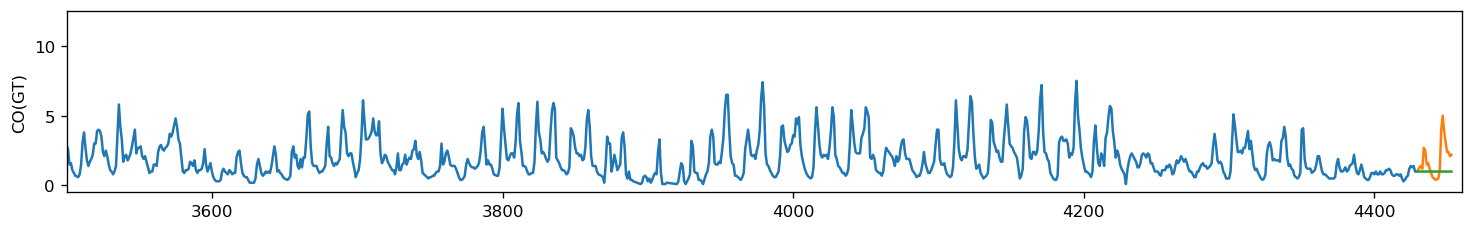

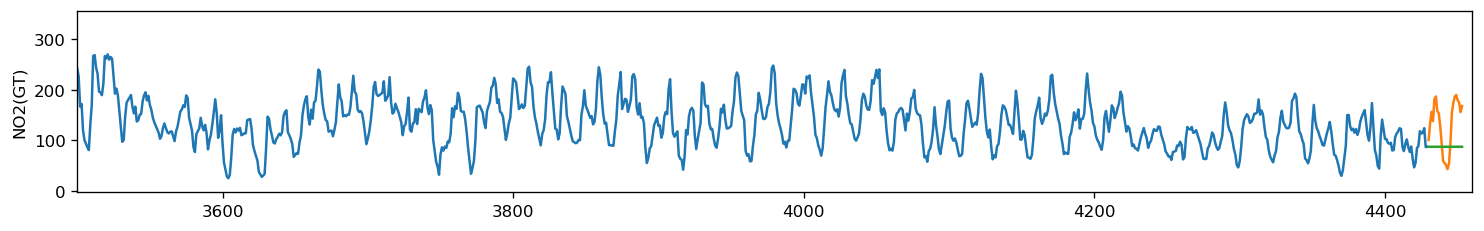

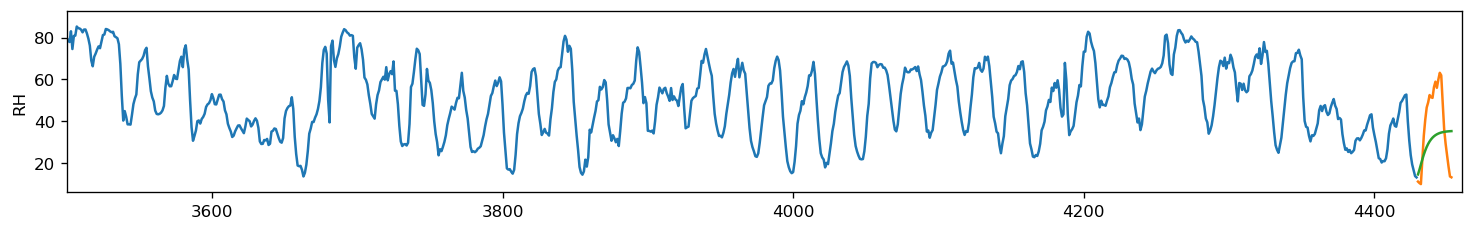

CPU times: user 6.32 s, sys: 192 ms, total: 6.52 s
Wall time: 1.9 s


In [33]:
%%time
forecast_arima = {}
for c in var_col:    
    model = ARIMA(train_aq[c].values, order=selected_order[c][0])
    model_fit = model.fit(disp=0)
    y_hat = model_fit.forecast(steps=24)[0]
    plt.figure(figsize=(15,2))
    plt.plot(train_aq[c].values, label='train')
    plt.plot(np.arange(len(test_aq))+len(train_aq), test_aq[c].values, label='train')
    plt.plot(np.arange(len(test_aq))+len(train_aq), y_hat, label='train')
    plt.ylabel(c)
    plt.xlim(xmin=3500, xmax=4460)
    plt.show()

## Preview to the next Chapter

ARIMA model is just one of the many algorithms that we will discuss. We can see the inherent limitations of ARIMA. In particular, we are not considering:
1. Trends and seasonality 
1. Long-range dependence
1. Multi-variate time series

These factors are generally more frequent and will be important in several applications. For example, trend is important in technical analysis in stock trading. This can be solved using Momentum Forecasting which will be discussed in Chapter 2, among other methods.

In Chapter 3, we will revisit the Air Quality example and use a multivariate approach.  We’ll introduce vector autoregressive (VAR) methods—a family of models that expresses each variable as a linear function of past lags and past lags of the other variables—and show that we can improve the forecasts by extending this to a multivariate time series problem. 


## References

The contents of this notebook is compiled from the following sources:
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- https://otexts.com/fpp2/arima.html
- https://people.duke.edu/~rnau/411arim.htm
- https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
- https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
- https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
- https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average
- C.Monterola, *"Notebook 10 Time Series Forecasting Method --- ARIMA MSDS2021"*
- Hyndman, R. J., & Khandakar, Y. (2008). Automatic time series forecasting: The forecast package for R. Journal of Statistical Software, 27(1), 1–22. https://doi.org/10.18637/jss.v027.i03